In [40]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout , GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model


import warnings
warnings.filterwarnings("ignore")

In [22]:
dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
#we want folders name only 
classes = [i for i in os.listdir(dir) if '.' not in i]
classes

['pituitary', 'notumor', 'meningioma', 'glioma']

In [23]:
def DF(dir,data_set):
    data=[]
    Dir = os.path.join(dir,data_set)
    for label in classes:
        folder = os.path.join(Dir,label)
        for filename in os.listdir(folder):
              file = os.path.join(folder,filename)
              data.append((file,label))
    return pd.DataFrame(data,columns=['path','label'])


In [24]:
dir='/kaggle/input/brain-tumor-mri-dataset'
train_data=DF(dir,'Training')
test_data=DF(dir,'Testing')
train_data.head(5)

,path,label
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary


In [25]:
print(train_data.shape,test_data.shape)

(5712, 2) (1311, 2)


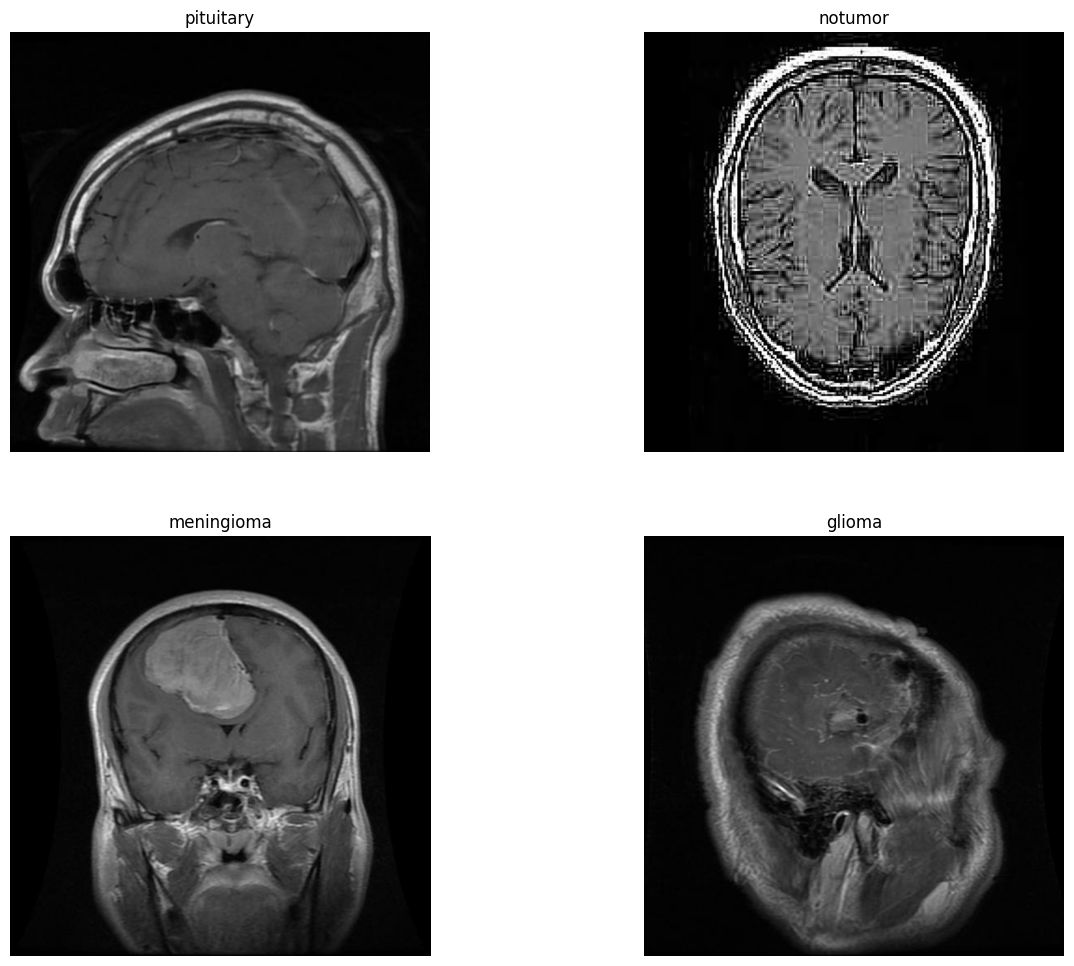

In [26]:
ind =0
plt.figure(figsize=(15,12))
for i in train_data['label'].unique():
    im =plt.imread(train_data[train_data['label']==i].iloc[0,0])
    im= cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.subplot(2,2,ind+1)
    plt.imshow(im)
    plt.title(i)
    plt.axis('off')
    ind+=1

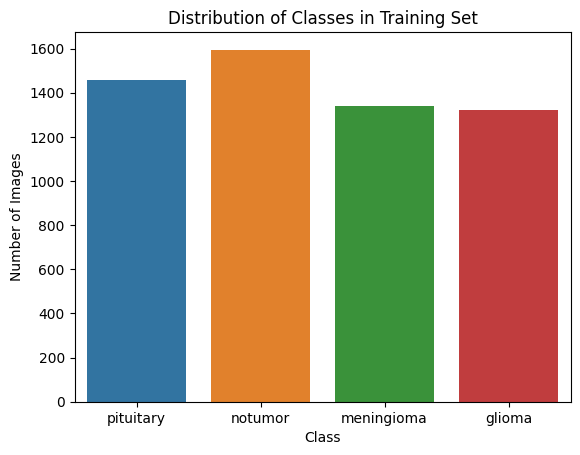

In [27]:
sns.countplot(data=train_data,x='label')

plt.title("Distribution of Classes in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [28]:
train_image = ImageDataGenerator(
    rescale=1./255,
    rotation_range=12,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.1
)

test_image = ImageDataGenerator(rescale=1./255)

In [29]:
BatchSize=32
ImageSize=(224,224)

train = train_image.flow_from_dataframe(
    dataframe=train_data ,
    x_col='path',
    y_col='label',
    target_size=ImageSize ,
    batch_size=BatchSize ,
    class_mode='categorical',
    seed=42,
    color_mode='rgb',
    shuffle=True,
    subset='training'
    
)
val = train_image.flow_from_dataframe(
    dataframe=train_data ,
    x_col='path',
    y_col='label',
    target_size=ImageSize ,
    batch_size=BatchSize ,
    seed=42,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    subset='validation'
)

test = test_image.flow_from_dataframe(
    dataframe=test_data ,
    x_col='path',
    y_col='label',
    target_size=ImageSize ,
    batch_size=BatchSize ,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)
    


Found 5141 validated image filenames belonging to 4 classes.
Found 571 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [34]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the VGG16 base model
vgg_base.trainable = False

# Create a new model on top of the VGG16 base
model = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])

#Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#model.summary()


In [35]:
early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('brain_tumor.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)


In [36]:
history = model.fit(
    train,
    epochs=100,
    validation_data=val,
    callbacks=[early,checkpoint,reduce_lr]
)


Epoch 1/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1686s 10s/step - accuracy: 0.6202 - loss: 1.7798 - val_accuracy: 0.9072 - val_loss: 0.2790 - learning_rate: 0.0010
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1711s 11s/step - accuracy: 0.8509 - loss: 0.4082 - val_accuracy: 0.7881 - val_loss: 0.5589 - learning_rate: 0.0010
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1672s 10s/step - accuracy: 0.8667 - loss: 0.3534 - val_accuracy: 0.9737 - val_loss: 0.1115 - learning_rate: 0.0010
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1671s 10s/step - accuracy: 0.8766 - loss: 0.3296 - val_accuracy: 0.9335 - val_loss: 0.2029 - learning_rate: 0.0010
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1711s 11s/step - accuracy: 0.9038 - loss: 0.2637 - val_accuracy: 0.7356 - val_loss: 0.6894 - learning_rate: 0.0010
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1682s 10s/step - accuracy: 0.9271 - loss: 0.1998 - val_accuracy: 0.9177 - val_loss: 0.2215 - learning_rate: 2.0000e-04


In [ ]:

print("Train Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])


Train Accuracy: 0.9291966557502747
Validation Accuracy: 0.917688250541687


In [ ]:
loss, acc = model.evaluate(test)
print("Test Accuracy:", acc)

41/41 ━━━━━━━━━━━━━━━━━━━━ 376s 9s/step - accuracy: 0.9507 - loss: 0.1669
Test Accuracy: 0.8695651888847351


In [ ]:
y_pred_probs = model.predict(test)
y_pred = np.argmax(y_pred_probs, axis=1)


y_true = test.classes  

class_names = list(test.class_indices.keys())


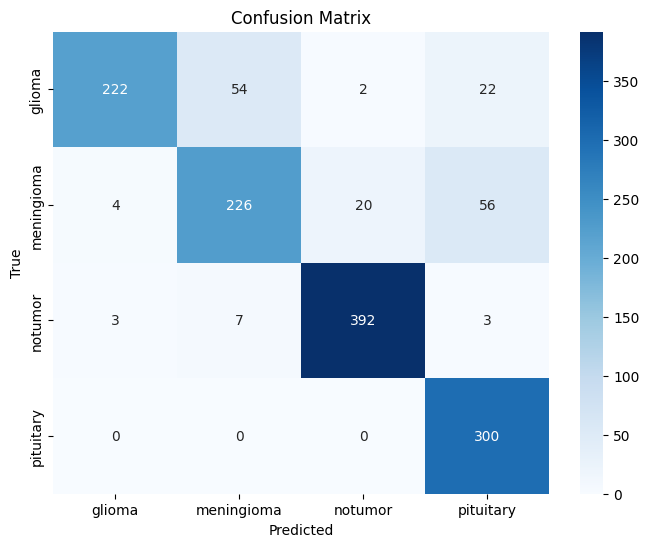

In [41]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [42]:
#Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

      glioma       0.97      0.74      0.84       300
  meningioma       0.79      0.74      0.76       306
     notumor       0.95      0.97      0.96       405
   pituitary       0.79      1.00      0.88       300

    accuracy                           0.87      1311
   macro avg       0.87      0.86      0.86      1311
weighted avg       0.88      0.87      0.87      1311

